# Sentiment Analysis with a Metamodel (CNN, CNN + GloVe, GRU, GRU + GloVe)

In this notebook is intended to show how now that we have four decent and diverse models, we can combine them, just averaging their results, in order to get a much better metamodel.

---
# IMPORTS
Let's import the modules we will use

In [1]:
import os
import pickle
import numpy as np


import pandas as pd
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve,log_loss
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('seaborn')

---
# LOAD THE DATA
We will load the test labels, the star rank of the test reviews, and the probabilities for the test set predicted by our four models.


In [3]:
#Load the test labels
with open('test_y.pkl','rb') as f:
    test_y = pickle.load(f)
#Load the stars of each review
with open('test_stars.pkl','rb') as f:
    test_stars = pickle.load(f)

In [4]:
#Load test_probas:
#GloVe_CNN
with open('GloVe_CNN_probas.pkl','rb') as f:
    GloVe_CNN_probas = pickle.load(f)
#Simple_CNN
with open('Simple_CNN_probas.pkl','rb') as f:
    Simple_CNN_probas = pickle.load(f)
#GloVe_GRU
with open('GloVe_GRU_probas.pkl','rb') as f:
    GloVe_GRU_probas = pickle.load(f)
#Simple_GRU
with open('Simple_GRU_probas.pkl','rb') as f:
    Simple_GRU_probas = pickle.load(f)

---
# HOW DID THE MODEL PERFORMED?
Let's print as summary how the models performed on the test set


In [5]:
for name,probas in zip(['Simple CNN', 'Simple GRU', 'GloVe CNN', 'GloVe GRU'],
                       [Simple_CNN_probas,Simple_GRU_probas,GloVe_CNN_probas, GloVe_GRU_probas]):
    print(name,'::')
    print(f'Loss: {log_loss(y_pred=probas,y_true=test_y):.4f}\tAccuracy:{accuracy_score(y_pred=(probas>=0.5),y_true=test_y):.4f}')
    

Simple CNN ::
Loss: 0.3244	Accuracy:0.8609
Simple GRU ::
Loss: 0.3043	Accuracy:0.8724
GloVe CNN ::
Loss: 0.2846	Accuracy:0.8797
GloVe GRU ::
Loss: 0.2625	Accuracy:0.8906


---
# COMBINING THE FOUR MODELS INTO A METAMODEL
Let's explore how the predictions improve by considering the average of the four models

In [6]:
#Four models average
four_probas = (Simple_CNN_probas + Simple_GRU_probas + GloVe_CNN_probas + GloVe_GRU_probas)/4
print(f'Loss: {log_loss(y_pred=four_probas,y_true=test_y):.4f}\tAccuracy:{accuracy_score(y_pred=(four_probas>=0.5),y_true=test_y):.4f}')

Loss: 0.2079	Accuracy:0.9716


The accuracy is boosted 8 points compare to the best model of the mix and 11 points compare to the worst model of the mix! 

In [7]:
test_cm = pd.DataFrame(cm(test_y, four_probas>=0.5, labels=[1,0]), index=['Label_1', 'Label_0'], columns=['Pred_1','Pred_0'] )
test_cm

,Pred_1,Pred_0
Label_1,12201,299
Label_0,412,12088


Most of the errors come from negative reviews misclasified as positive reviews

In [8]:
print(f'Accuracy of the model: {accuracy_score(test_y, four_probas>=0.5):.4f}')
print(f'Precision of the model for positive reviews: {precision_score(test_y, four_probas>=0.5, pos_label=1):.4f}')
print(f'Recall of the model for positive reviews: {recall_score(test_y, four_probas>=0.5, pos_label=1):.4f}')
print(f'f1-score of the model for positive reviews: {f1_score(test_y, four_probas>=0.5, pos_label=1):.4f}')

Accuracy of the model: 0.9716
Precision of the model for positive reviews: 0.9673
Recall of the model for positive reviews: 0.9761
f1-score of the model for positive reviews: 0.9717


In [9]:
print(f'Accuracy of the model: {accuracy_score(test_y, four_probas>=0.5):.4f}')
print(f'Precision of the model for negative reviews: {precision_score(test_y, four_probas>=0.5, pos_label=0):.4f}')
print(f'Recall of the model for negative reviews: {recall_score(test_y, four_probas>=0.5, pos_label=0):.4f}')
print(f'f1-score of the model for negative reviews: {f1_score(test_y, four_probas>=0.5, pos_label=0):.4f}')

Accuracy of the model: 0.9716
Precision of the model for negative reviews: 0.9759
Recall of the model for negative reviews: 0.9670
f1-score of the model for negative reviews: 0.9714


In [10]:
#Positive reviews
pos_pre_rec = pd.DataFrame({name: values for values, name in 
                            zip(precision_recall_curve(test_y, four_probas, pos_label=1)[:2],['precision','recall'])})
#Negative reviews
neg_pre_rec = pd.DataFrame({name: values for values, name in 
                            zip(precision_recall_curve(test_y, 1-four_probas, pos_label=0)[:2],['precision','recall'])})

C:\Users\Adrian\Anaconda3\envs\my-pytorch-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


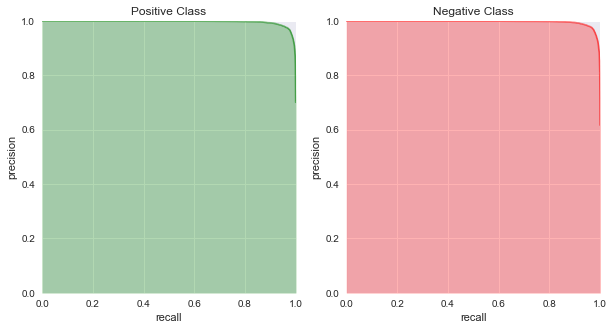

In [11]:
plt.figure(num=1,figsize=(10,5))
#Positive reviews
ax = plt.subplot(1,2,1) 
sns.lineplot(x='recall',y='precision',data=pos_pre_rec,ax=ax,color='green', alpha=0.5)
plt.fill_between(pos_pre_rec.recall.values, pos_pre_rec.precision.values, color='green', alpha=0.3)
plt.title('Positive Class')
plt.xlim(0,1)
plt.ylim(0,1)
#Negative reviews
ax = plt.subplot(1,2,2) 
sns.lineplot(x='recall',y='precision',data=neg_pre_rec,ax=ax,color='red', alpha=0.5)
plt.fill_between(neg_pre_rec.recall.values, neg_pre_rec.precision.values, color='red', alpha=0.3)
plt.title('Negative Class')
plt.xlim(0,1)
plt.ylim(0,1);

Awesome looking curves! It looks that the metamodel is able to recover more than 80% of the positive/negative reviews with nearly 100% of precision

In [12]:
stars = np.unique(test_stars)
stars.sort()
my_df={'Stars': stars, 
       'Avg Prob':[four_probas[test_stars==i].mean() for i in stars],
      'Pos Revs': [(four_probas[test_stars==i]>=0.5).mean()*100 for i in stars]}

my_df = pd.DataFrame(my_df)
my_df

,Stars,Avg Prob,Pos Revs
0,1,0.177621,3.365193
1,2,0.184339,3.258036
2,3,0.180723,3.541913
3,4,0.178628,2.960152
4,7,0.833681,97.312527
5,8,0.829841,97.263158
6,9,0.829971,97.696246
7,10,0.835320,97.899580


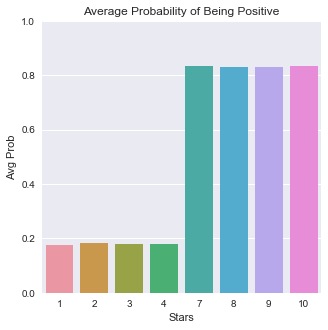

In [13]:
plt.figure(num=2,figsize=(5,5))
sns.barplot(x='Stars',y='Avg Prob',data=my_df)
plt.title('Average Probability of Being Positive')
plt.ylim(0,1);

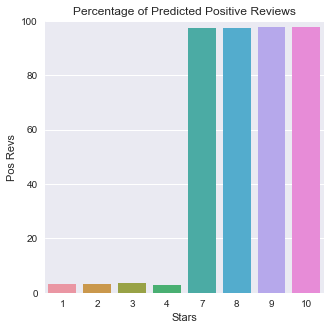

In [14]:
plt.figure(num=3,figsize=(5,5))
sns.barplot(x='Stars',y='Pos Revs',data=my_df)
plt.title('Percentage of Predicted Positive Reviews')
plt.ylim(0,100);

It is very interesting that the metamodel seems to perform equally well for each group of reviews (2-4 % of error)

---
# OTHER METAMODELS
Almost all of them produce accuracies over 90%

In [15]:
#Two CNN models average
new_probas = (Simple_CNN_probas + GloVe_CNN_probas )/2
print(f'Loss: {log_loss(y_pred=new_probas,y_true=test_y):.4f}\tAccuracy:{accuracy_score(y_pred=(new_probas>=0.5),y_true=test_y):.4f}')

Loss: 0.2726	Accuracy:0.8897


In [16]:
#Two GRU models average
new_probas = (Simple_GRU_probas + GloVe_GRU_probas )/2
print(f'Loss: {log_loss(y_pred=new_probas,y_true=test_y):.4f}\tAccuracy:{accuracy_score(y_pred=(new_probas>=0.5),y_true=test_y):.4f}')

Loss: 0.2081	Accuracy:0.9513


In [17]:
#Two GloVe models average
new_probas = (GloVe_CNN_probas + GloVe_GRU_probas )/2
print(f'Loss: {log_loss(y_pred=new_probas,y_true=test_y):.4f}\tAccuracy:{accuracy_score(y_pred=(new_probas>=0.5),y_true=test_y):.4f}')

Loss: 0.2051	Accuracy:0.9532


In [18]:
#Two simple models average
new_probas = (Simple_CNN_probas + Simple_GRU_probas )/2
print(f'Loss: {log_loss(y_pred=new_probas,y_true=test_y):.4f}\tAccuracy:{accuracy_score(y_pred=(new_probas>=0.5),y_true=test_y):.4f}')

Loss: 0.2368	Accuracy:0.9406


In [19]:
#Simple GRU + GloVe CNN
new_probas = (GloVe_CNN_probas + Simple_GRU_probas )/2
print(f'Loss: {log_loss(y_pred=new_probas,y_true=test_y):.4f}\tAccuracy:{accuracy_score(y_pred=(new_probas>=0.5),y_true=test_y):.4f}')

Loss: 0.2235	Accuracy:0.9467


In [20]:
#GloVe GRU + Simple CNN
new_probas = (Simple_CNN_probas + GloVe_GRU_probas )/2
print(f'Loss: {log_loss(y_pred=new_probas,y_true=test_y):.4f}\tAccuracy:{accuracy_score(y_pred=(new_probas>=0.5),y_true=test_y):.4f}')

Loss: 0.2186	Accuracy:0.9470


FUN FACT: Using only the three best moles provides the best performance

In [21]:
#Best Three: GloVe GRU + Simple GRU + GloVe CNN
three_probas = (GloVe_CNN_probas + GloVe_GRU_probas + Simple_GRU_probas)/3
print(f'Loss: {log_loss(y_pred=three_probas,y_true=test_y):.4f}\tAccuracy:{accuracy_score(y_pred=(three_probas>=0.5),y_true=test_y):.4f}')

Loss: 0.1999	Accuracy:0.9731


In [22]:
test_cm = pd.DataFrame(cm(test_y, new_probas>=0.5, labels=[1,0]), index=['Label_1', 'Label_0'], columns=['Pred_1','Pred_0'] )
test_cm

,Pred_1,Pred_0
Label_1,11881,619
Label_0,707,11793


In [23]:
print(f'Accuracy of the model: {accuracy_score(test_y, three_probas>=0.5):.4f}')
print(f'Precision of the model for positive reviews: {precision_score(test_y, three_probas>=0.5, pos_label=1):.4f}')
print(f'Recall of the model for positive reviews: {recall_score(test_y, three_probas>=0.5, pos_label=1):.4f}')
print(f'f1-score of the model for positive reviews: {f1_score(test_y, three_probas>=0.5, pos_label=1):.4f}')

Accuracy of the model: 0.9731
Precision of the model for positive reviews: 0.9680
Recall of the model for positive reviews: 0.9786
f1-score of the model for positive reviews: 0.9732


In [24]:
print(f'Accuracy of the model: {accuracy_score(test_y, four_probas>=0.5):.4f}')
print(f'Precision of the model for negative reviews: {precision_score(test_y, three_probas>=0.5, pos_label=0):.4f}')
print(f'Recall of the model for negative reviews: {recall_score(test_y, three_probas>=0.5, pos_label=0):.4f}')
print(f'f1-score of the model for negative reviews: {f1_score(test_y, three_probas>=0.5, pos_label=0):.4f}')

Accuracy of the model: 0.9716
Precision of the model for negative reviews: 0.9783
Recall of the model for negative reviews: 0.9676
f1-score of the model for negative reviews: 0.9729


In [25]:
#Positive reviews
pos_pre_rec = pd.DataFrame({name: values for values, name in 
                            zip(precision_recall_curve(test_y, three_probas, pos_label=1)[:2],['precision','recall'])})
#Negative reviews
neg_pre_rec = pd.DataFrame({name: values for values, name in 
                            zip(precision_recall_curve(test_y, 1-three_probas, pos_label=0)[:2],['precision','recall'])})

C:\Users\Adrian\Anaconda3\envs\my-pytorch-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


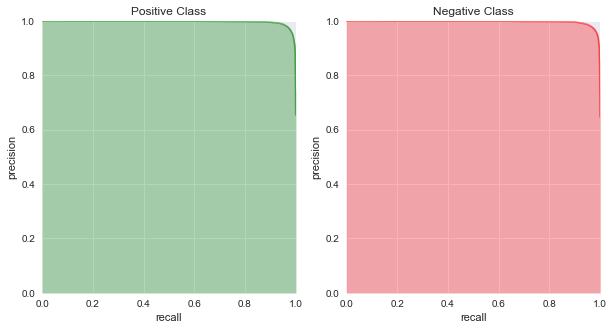

In [26]:
plt.figure(num=1,figsize=(10,5))
#Positive reviews
ax = plt.subplot(1,2,1) 
sns.lineplot(x='recall',y='precision',data=pos_pre_rec,ax=ax,color='green', alpha=0.5)
plt.fill_between(pos_pre_rec.recall.values, pos_pre_rec.precision.values, color='green', alpha=0.3)
plt.title('Positive Class')
plt.xlim(0,1)
plt.ylim(0,1)
#Negative reviews
ax = plt.subplot(1,2,2) 
sns.lineplot(x='recall',y='precision',data=neg_pre_rec,ax=ax,color='red', alpha=0.5)
plt.fill_between(neg_pre_rec.recall.values, neg_pre_rec.precision.values, color='red', alpha=0.3)
plt.title('Negative Class')
plt.xlim(0,1)
plt.ylim(0,1);

In [27]:
stars = np.unique(test_stars)
stars.sort()
my_df={'Stars': stars, 
       'Avg Prob':[three_probas[test_stars==i].mean() for i in stars],
      'Pos Revs': [(three_probas[test_stars==i]>=0.5).mean()*100 for i in stars]}

my_df = pd.DataFrame(my_df)
my_df

,Stars,Avg Prob,Pos Revs
0,1,0.173510,3.265631
1,2,0.181750,3.475239
2,3,0.177832,3.069658
3,4,0.174730,3.149905
4,7,0.843550,98.179454
5,8,0.838127,97.298246
6,9,0.838080,97.866894
7,10,0.845376,98.019604


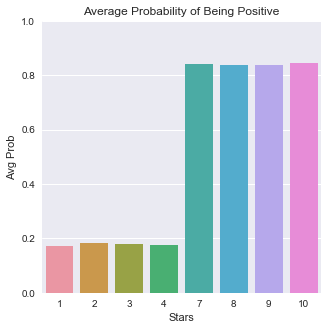

In [28]:
plt.figure(num=2,figsize=(5,5))
sns.barplot(x='Stars',y='Avg Prob',data=my_df)
plt.title('Average Probability of Being Positive')
plt.ylim(0,1);

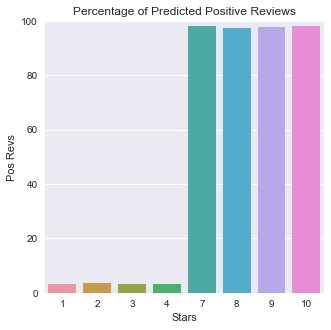

In [29]:
plt.figure(num=3,figsize=(5,5))
sns.barplot(x='Stars',y='Pos Revs',data=my_df)
plt.title('Percentage of Predicted Positive Reviews')
plt.ylim(0,100);